In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit as sigmoid

In [2]:
# Load data stored in numpy format
Data = np.load("Handwritten_data2.npz")
Data.files

['labels', 'data']

In [3]:
y = Data['labels']
m = y.size
X = Data['data']
X.shape

(5000, 400)

In [4]:
# Neural Network Parameters
ip_size = 400 
hidden_size = 25
num_labels = np.unique(y).size
num_labels

10

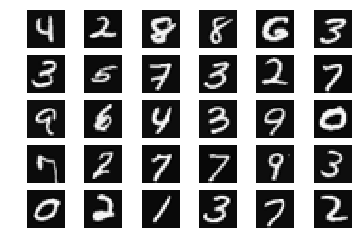

In [5]:
# Plotting 30 random examples from X
indices = np.random.randint(0,m,30)

fig = plt.figure()
for i in range (30):
    img = X[indices[i]].reshape(20,20,order='F')
    fig.add_subplot(5,6,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis("off")

plt.show()

In [6]:
# Loading the pre-intialized NN parameters
# These will be used to verify the functioning of the Cost Function
Weights = np.load('tempWeights.npz')
Theta1 = Weights['Theta1']
Theta2 = Weights['Theta2']
# Unrolling the parameters into a vector
temp_params = np.append(Theta1,Theta2)
Theta1.shape,Theta2.shape

((25, 401), (10, 26))

In [7]:
# Sigmoid Gradient function
def sigmoid_grad(x):
    g = sigmoid(x)
    return (g*(1-g))
    

In [8]:
# Evaluating Sigmoid Gradient
sigmoid_grad([-1,-0.5,0,0.5,1])

array([ 0.19661193,  0.23500371,  0.25      ,  0.23500371,  0.19661193])

In [9]:
# Cost Function and Gradients
# Feedforward the neural network and return the cost in variable J

def costFunction(nn_params,i_size,h_size,labels,X,y,lamb):
    m = X.shape[0]
    # Reshaping the Parameters
    Theta1 = nn_params[:h_size*(i_size +1)].reshape(h_size,i_size+1)
    Theta2 = nn_params[h_size*(i_size +1):].reshape(labels,h_size+1)
    # For training a NN we recode the labels as vectors containing
    # only 0 or 1 values
    eye_mat = np.eye(labels)
    y_mat = eye_mat[:,y]
    
    # Forward Propagation
    X = np.c_[np.ones(m),X]
    z2 = X.dot(Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones(m),a2]
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    h = a3.T
    
    # Calculating the cost
    J = (-1.0/m)*np.sum(y_mat*np.log(h) + (1-y_mat)*np.log(1-h))
    # Adding Regularization Term (Not considering terms that correspond to bias)
    J = J + (lamb/(2.0*m)) * (np.sum(Theta1[:,1:]**2)+ np.sum(Theta2[:,1:]**2))
    
    # Backpropagation
    delta3 = h-y_mat
    delta2 = ((Theta2[:,1:].T).dot(delta3)) * sigmoid_grad(z2.T)
    Acc_D2 = delta3.dot(a2)
    Acc_D1 = delta2.dot(X)
    
    # Gradients
    Theta2_grad = (1.0/m) * Acc_D2 
    Theta1_grad = (1.0/m) * Acc_D1
    # Adding Regularization Term (Not considering terms that correspond to bias)
    reg_term2 = np.c_[np.zeros(Theta2.shape[0]),Theta2[:,1:]]
    Theta2_grad = Theta2_grad + (lamb/float(m)) * reg_term2
    
    reg_term1 = np.c_[np.zeros(Theta1.shape[0]),Theta1[:,1:]]
    Theta1_grad = Theta1_grad + (lamb/float(m)) * reg_term1
    
    # Unrolling the gradients into a vector
    grad = np.append(Theta1_grad,Theta2_grad)
    
    return J,grad

In [10]:
# Cost and Grad with lambda = 0
J,G = costFunction(temp_params,ip_size,hidden_size,num_labels,X,y,0)
print J
print G

10.4414596728
[ 0.02797359  0.          0.         ...,  0.00552226  0.05182065
  0.00126207]


In [11]:
# Cost and Grad with lambda = 1
args = ip_size,hidden_size,num_labels,X,y,1
J,G = costFunction(temp_params,*args)
print J
print G


10.5376003667
[  2.79735891e-02  -2.11248326e-12   4.38829369e-13 ...,   5.47270560e-03
   5.20766639e-02   9.96564573e-04]


In [12]:
# Computing Gradient using Numerical Computation
def numgrad(theta,args):
    m = theta.size
    epsilon = 1e-4
    numgrad = np.zeros(m)
    perturb = np.zeros(m)
    for i in range(m):
        perturb[i] = epsilon
        loss1 = costFunction((theta-perturb),*args)[0] 
        loss2 = costFunction((theta+perturb),*args)[0]
        numgrad[i] = (loss2-loss1)/(2*epsilon);
        perturb[i]=0
    return numgrad

In [13]:
# Initialize the weights of a layer with fan_in incoming connections and fan_out outgoing connections
# using a fixed strategy, this will help in debugging
def debugInitialWeights(fan_out,fan_in):
    W = np.zeros((fan_out,fan_in +1))
    W =(np.sin(np.arange(1,W.size+1))/10).reshape(W.shape)
    return W  

In [14]:
# checkNNGradients  Creates a small neural network to check the backpropagation gradients
# It will output the analytical gradients produced by your backprop code and the numerical gradients 
# (computed using numgrad). These two gradient computations should result in very similar values
def checkNNGradients(lamb):
    i_size = 3; h_size = 3 ;num_labels = 3; m = 5
    # Generating random data
    Theta1 = debugInitialWeights(h_size,i_size)
    Theta2 = debugInitialWeights(num_labels,h_size)
    X = debugInitialWeights(m,i_size-1)
    y = np.mod(np.arange(m),num_labels)
    # Unroll parameters
    nn_params = np.append(Theta1,Theta2)
    
    args = i_size,h_size,num_labels,X,y,lamb
    G1 = costFunction(nn_params,*args)[1]
    G2 = numgrad(nn_params,args)
    print "The two columns below should be very similar"
    print "(Left-Backprop Gradients, Right-Numerical Gradient)"
    print np.c_[G1[:,np.newaxis],G2[:,np.newaxis]]
    print "The difference is less than 1e-9: %s" % np.allclose(G1,G2,rtol=1e-9,atol=1e-9)
    

In [15]:
# Checking Backprop w/o Regularization
checkNNGradients(lamb = 0)

The two columns below should be very similar
(Left-Backprop Gradients, Right-Numerical Gradient)
[[ -1.67407607e-03  -1.67407607e-03]
 [  2.01559293e-05   2.01559280e-05]
 [  3.49877111e-04   3.49877107e-04]
 [  3.57922891e-04   3.57922894e-04]
 [ -5.13333018e-03  -5.13333017e-03]
 [  3.90290328e-04   3.90290325e-04]
 [  4.49087678e-04   4.49087676e-04]
 [  9.49958883e-05   9.49958867e-05]
 [ -3.88117379e-03  -3.88117379e-03]
 [  4.02480309e-04   4.02480309e-04]
 [  1.36027964e-04   1.36027964e-04]
 [ -2.55487864e-04  -2.55487869e-04]
 [  1.24904785e-01   1.24904785e-01]
 [  6.49053029e-02   6.49053029e-02]
 [  5.99422224e-02   5.99422224e-02]
 [  6.32813548e-02   6.32813547e-02]
 [  9.28155988e-02   9.28155988e-02]
 [  4.87480585e-02   4.87480585e-02]
 [  4.41460450e-02   4.41460450e-02]
 [  4.70247564e-02   4.70247564e-02]
 [  2.84472304e-01   2.84472304e-01]
 [  1.48101428e-01   1.48101428e-01]
 [  1.35184382e-01   1.35184382e-01]
 [  1.45593145e-01   1.45593145e-01]]
The difference

In [16]:
# Checking Backprop with Regularization
checkNNGradients(lamb = 2)

The two columns below should be very similar
(Left-Backprop Gradients, Right-Numerical Gradient)
[[-0.00167408 -0.00167408]
 [ 0.03639205  0.03639205]
 [ 0.00599468  0.00599468]
 [-0.02991418 -0.02991418]
 [-0.00513333 -0.00513333]
 [-0.01078633 -0.01078633]
 [ 0.02672855  0.02672855]
 [ 0.03966933  0.03966933]
 [-0.00388117 -0.00388117]
 [-0.02135836 -0.02135836]
 [-0.03986358 -0.03986358]
 [-0.0217184  -0.0217184 ]
 [ 0.12490479  0.12490479]
 [ 0.1012772   0.1012772 ]
 [ 0.06558702  0.06558702]
 [ 0.03300925  0.03300925]
 [ 0.0928156   0.0928156 ]
 [ 0.03757144  0.03757144]
 [ 0.07042551  0.07042551]
 [ 0.08659909  0.08659909]
 [ 0.2844723   0.2844723 ]
 [ 0.12634058  0.12634058]
 [ 0.09518477  0.09518477]
 [ 0.12413023  0.12413023]]
The difference is less than 1e-9: True


In [17]:
# Random Intialization of weights for symmetry breaking
e_init = np.sqrt(6)/np.sqrt(ip_size + num_labels)
e_init=round(e_init,3)
T1 = np.random.rand(hidden_size,ip_size+1) * 2*e_init-e_init
T2 = np.random.rand(num_labels,hidden_size+1) * 2*e_init-e_init
init_params = np.append(T1,T2)  
T1.shape,T2.shape

((25, 401), (10, 26))

In [18]:
# Optimizing the parameters theta using scipy.optimize 
def find_min(init_theta,par):
    res = minimize(costFunction,init_theta,args=(par),method = 'CG',jac = True
               ,options={'maxiter':250,'disp':True})  
    return res.x


In [19]:
%%time
# Training the NN
lamb = 1
par = ip_size,hidden_size,num_labels,X,y,lamb
final_params = find_min(init_params,par)

         Current function value: 0.325988
         Iterations: 250
         Function evaluations: 526
         Gradient evaluations: 526
CPU times: user 25.8 s, sys: 504 ms, total: 26.3 s
Wall time: 13.2 s


In [20]:
# Obtaining Theta1_final and Theta2_final from final_params
Theta1_final = final_params[:hidden_size*(ip_size +1)].reshape(hidden_size,ip_size+1)
Theta2_final = final_params[hidden_size*(ip_size +1):].reshape(num_labels,hidden_size+1)

In [21]:
# Predict the labels
def predict(Theta1,Theta2,X):
    m = X.shape[0]
    X = np.c_[np.ones(m),X]
    z2 = X.dot(Theta1.T)
    a2 = sigmoid(np.c_[np.ones(m),z2])
    z3 = a2.dot(Theta2.T)
    h = sigmoid(z3)
    p = np.argmax(h,1)
    return p 

In [22]:
# Getting Accuracy on the Training Set
y_pred = predict(Theta1_final,Theta2_final,X)
accuracy = np.mean(y_pred == y)*100
print "Accuracy on the Training Set %s %%" % round(accuracy,2)
print "NN made errors in predicting %s samples out of 5000 in the training set " % np.count_nonzero(y != y_pred)

Accuracy on the Training Set 99.5 %
NN made errors in predicting 25 samples out of 5000 in the training set 


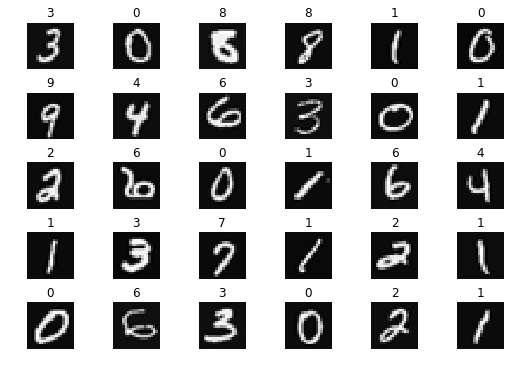

In [23]:
# Plotting 30 random examples from X with their predicted labels
indices = np.random.randint(0,m,30)
fig = plt.figure(figsize = (9,6))

for i in range (30):
    img = X[indices[i]].reshape(20,20,order='F')
    fig.add_subplot(5,6,i+1)    
    plt.title(y_pred[indices[i]])
    plt.imshow(img,cmap='gray')
    plt.axis("off")

plt.subplots_adjust(hspace = 0.5)    
plt.show()